<a href="https://colab.research.google.com/github/RomaricRichou/pie2021_option_swing/blob/main/SimulationsMC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
## Exemple de référence

def american_mc(T,N,steps,S,r,sigma,K, typeCP):
	import numpy as np
	if typeCP=="call":
		typeCP=1
	else:
		typeCP=-1
	
	dt = np.float(T) / steps
	df = np.exp(-r * dt)
	# simulation of index levels
	SPath = np.zeros((steps + 1, N))
	SPath[0] = S
	
	z=np.random.randn(steps,N)

	for t in range(1, steps + 1):
		SPath[t] = SPath[t - 1] * np.exp((r - 0.5 * sigma ** 2) * dt + sigma * np.sqrt(dt) *z[t-1])

	# case-based calculation of payoff
	h = np.maximum(typeCP*(SPath - K), 0)
	# LSM algorithm
	V = np.copy(h)
	for t in range(steps - 1, 0, -1):
		reg = np.polyfit(SPath[t], V[t + 1] * df, 7)
		C = np.polyval(reg, SPath[t])
		V[t] = np.where(C > h[t], V[t + 1] * df, h[t])
	# MCS estimator
	option = df * 1 / N * np.sum(V[1])
	return option

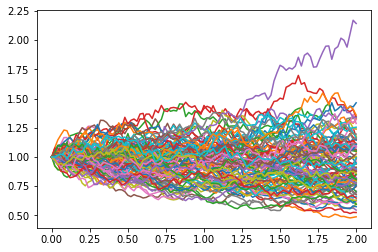

Les quantiles d'ordre 5%, 50%, 95% [0.59377268 0.90431829 1.33638837]
Le temps de calcul est de : 0.34381235700001866


In [ ]:
## Création d'un échantillon Normal : Df = F*sigma*dBt
def normal_mc(T,N,steps,S,r,sigma, show=False):
  import numpy as np
	
  dt = np.float(T) / steps
  # simulation of index levels
  SPath = np.zeros((steps + 1, N))
  SPath[0] = S
	
  z=np.random.randn(steps,N)

  for t in range(1, steps + 1):
    SPath[t] = SPath[t - 1] * np.exp((r - 0.5 * sigma ** 2) * dt + sigma * np.sqrt(dt) *z[t-1])

  if show:
    import matplotlib.pyplot as plt
    time=[i*dt for i in range(steps+1)]
    for i in range(N):
      plt.plot(time, SPath[:,i])
    plt.show()
  return SPath

## Visualisation des simulations et détermination des quantiles (utiles en terme de gestion de risque ?) + Affichage temps de calcul
import numpy as np
import time

start=time.perf_counter()
mc_test=normal_mc(2,100,100,1,0,0.2,show = True)
end=time.perf_counter()


print("Les quantiles d'ordre 5%, 50%, 95%",np.quantile(mc_test[100],[0.05,0.5,0.95]))
#print("Le pourcentile de 1 est :",np.percentile(mc_test[100],1))
print("Le temps de calcul est de :",end-start)

In [ ]:
!pip install -q pulp

     |████████████████████████████████| 14.2 MB 9.0 MB/s 


Maximisation_sur_une_trajectoire:
MAXIMIZE
-2.2461916548332526*f_0 + -2.2461916548332526*f_1 + -2.2461916548332526*f_2 + -2.2461916548332526*f_3 + -2.2461916548332526*f_4 + -2.2461916548332526*f_5 + -2.2461916548332526*f_6 + -2.2461916548332526*f_7 + -2.2461916548332526*f_8 + -2.2461916548332526*f_9 + 0.0
SUBJECT TO
_C1: f_0 - i_0 <= 0

_C2: f_0 - 0.5 i_0 >= 0

_C3: f_1 - i_1 <= 0

_C4: f_1 - 0.5 i_1 >= 0

_C5: f_2 - i_2 <= 0

_C6: f_2 - 0.5 i_2 >= 0

_C7: f_3 - i_3 <= 0

_C8: f_3 - 0.5 i_3 >= 0

_C9: f_4 - i_4 <= 0

_C10: f_4 - 0.5 i_4 >= 0

_C11: f_5 - i_5 <= 0

_C12: f_5 - 0.5 i_5 >= 0

_C13: f_6 - i_6 <= 0

_C14: f_6 - 0.5 i_6 >= 0

_C15: f_7 - i_7 <= 0

_C16: f_7 - 0.5 i_7 >= 0

_C17: f_8 - i_8 <= 0

_C18: f_8 - 0.5 i_8 >= 0

_C19: f_9 - i_9 <= 0

_C20: f_9 - 0.5 i_9 >= 0

_C21: f_0 + f_1 + f_2 + f_3 + f_4 + f_5 + f_6 + f_7 + f_8 + f_9 >= 1

_C22: f_0 + f_1 + f_2 + f_3 + f_4 + f_5 + f_6 + f_7 + f_8 + f_9 <= 2.5

_C23: i_0 + i_1 + i_2 + i_3 + i_4 + i_5 + i_6 + i_7 + i_8 + i_9 <= 5


LpAffineExpression()

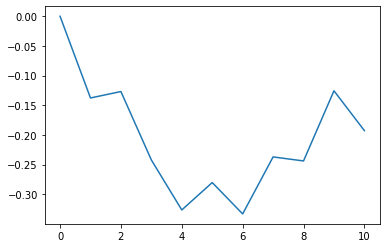

In [ ]:
from pulp import *
import numpy as np
def res_mipl(T,trials,steps,S,r,s,qmin,qmax,Qmin,Qmax, debug = False):
  #Constructions des valeurs utiles
  dt=float(T)/steps

  #Construction du modèle
  model = LpProblem("Maximisation_sur_une_trajectoire",LpMaximize)

  variable_names = [i for i in range(0, steps)]

  #Variables
  f=LpVariable.matrix("f",variable_names)

  i=LpVariable.matrix("i",variable_names,cat="Integer",lowBound=0,upBound=1)

  #Fonction objectif
  obj_func = lpSum(f*(s-S))
  model+= obj_func

  #Contraintes
  for k in range(steps):
    model+= (f[k]<=i[k]*qmax)
    model+= (f[k]>=i[k]*qmin)
  model+= (Qmin<=lpSum(f))
  model+= (lpSum(f)<=Qmax)
  model+= (lpSum(i)<=trials)

  #Résolution
  if debug :
    print(model)
  model.solve()
  z =[model.variables()[k].value() for k in range(steps)]
  if debug :
    print([model.variables()[k] for k in range(steps)])
    print([model.variables()[k].value() for k in range(steps)])
    print(lpSum(z*(s-S)))
    import matplotlib.pyplot as plt
    plt.plot(s-S)
  return(lpSum(z*(s-S)))

#Tests fonction
mc_test=normal_mc(2,1,10,1,0,0.2,show = False)
res_mipl(2,5,10,1,0,mc_test,0.5,1,1,2.5, debug = True)